In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import shap
shap.plots.initjs()



In [174]:
df_train_val = pd.read_csv('heart_failure/train_val_split.csv')
df_test = pd.read_csv('heart_failure/test_split.csv')

df = pd.concat([df_train_val, df_test], axis=0)

In [175]:
df_train_val

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
730,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
731,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
732,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1


In [196]:
scaler = StandardScaler()

    
def create_bar_plot(names, values,title='Bar Plot'):
    plt.bar(names, values)
    plt.xlabel('Names')
    plt.ylabel('Values')
    plt.title(title)
    plt.xticks(rotation=90)
    
    plt.savefig(f'images/{title}.png')
    
    plt.show()

def standardize_data(data):
    if hasattr(scaler, 'scale_'):
        normalized_data = scaler.transform(data)
    else:
        normalized_data = scaler.fit_transform(data)
    return normalized_data

import os

def plot_binning(series, bins=10, name='data'):
    plt.hist(series, bins=bins, edgecolor='black')
    plt.title(name)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    
    plt.savefig(f'images/{name}.png')
    
    plt.show()
    
def plot_categorical(df, column):
    # Get the counts of each category
    counts = df[column].value_counts()

    plt.bar(counts.index, counts.values)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title(f'Occurrence of Each Category in {column}')
    plt.xticks(rotation=45)
    
    plt.savefig(f'images/{column}.png')
    
    plt.show()
    
def plot_column(df, column):
    if column in categorical:
        # If the column is categorical, create a bar plot
        values = df[column].value_counts()
        names = values.index
        create_bar_plot(names, values, title=column)
    elif column in nummeric:
        # If the column is numerical, create a histogram
        plot_binning(df[column], bins=100, name=column)
    else:
        print(f"Column {column} not found in categorical or nummeric lists.")
    
categorical = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'FastingBS']
nummeric = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [177]:
def create_dataloaders_from_arrays(X_train, y_train, batch_size=64):
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    
    # Create TensorDatasets
    train_data = TensorDataset(X_train, y_train)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    return train_loader

def train_model(model, train_loader, test_loader, device='cpu', epochs=10):
    # Move model to the device
    
    if not (device == 'cpu'):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:
            # Move data and target to the device
            target = target.view(-1, 1)
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)

        # Print training statistics 
        train_loss = train_loss/len(train_loader.dataset)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
        
def make_predictions(model, array):
    # Convert the array to a PyTorch tensor
    tensor = torch.from_numpy(array).float()

    # Use the model to make predictions
    output = model(tensor)

    # Convert the output to probabilities using the sigmoid function
    probabilities = torch.sigmoid(output).detach().numpy()

    return probabilities

In [178]:
feature_names = df.columns
data_types = ['numerical' if df[col].dtype in ['int64', 'float64'] else 'categorical' for col in df.columns]
third_column = [f"{df[col].min()}-{df[col].max()}" if df[col].dtype in ['int64', 'float64'] else len(df[col].unique()) for col in df.columns]

table_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Data Type': data_types,
    'Range / Number of Categories': third_column
})

latex_code = table_df.to_latex(index=False)
print(latex_code)


\begin{tabular}{lll}
\toprule
Feature Name & Data Type & Range / Number of Categories \\
\midrule
Age & numerical & 28-77 \\
Sex & categorical & 2 \\
ChestPainType & categorical & 4 \\
RestingBP & numerical & 0-200 \\
Cholesterol & numerical & 0-603 \\
FastingBS & numerical & 0-1 \\
RestingECG & categorical & 3 \\
MaxHR & numerical & 60-202 \\
ExerciseAngina & categorical & 2 \\
Oldpeak & numerical & -2.6-6.2 \\
ST_Slope & categorical & 3 \\
HeartDisease & numerical & 0-1 \\
\bottomrule
\end{tabular}



Data Visualization and Preprocessing

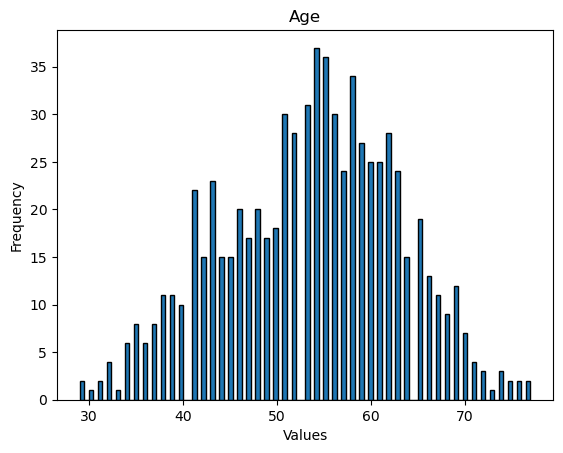

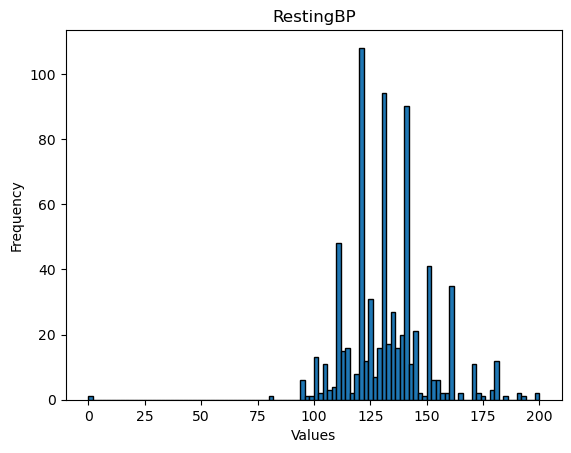

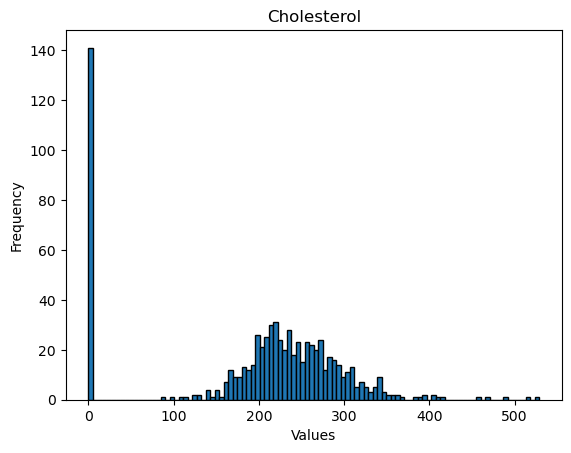

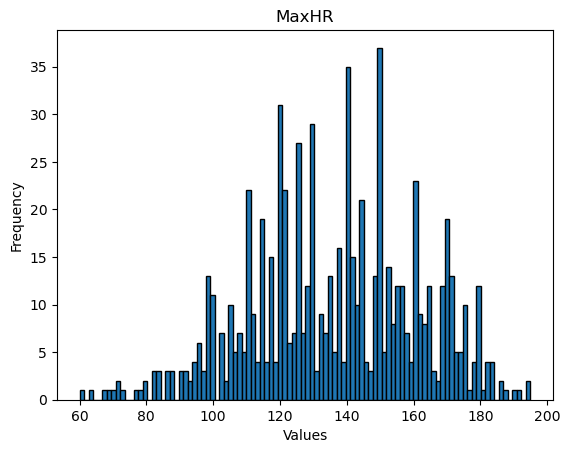

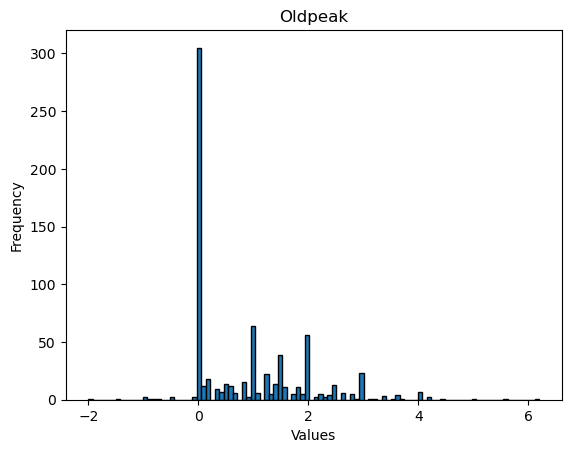

In [179]:
for col in nummeric:
    plot_column(df_train_val, column=col)

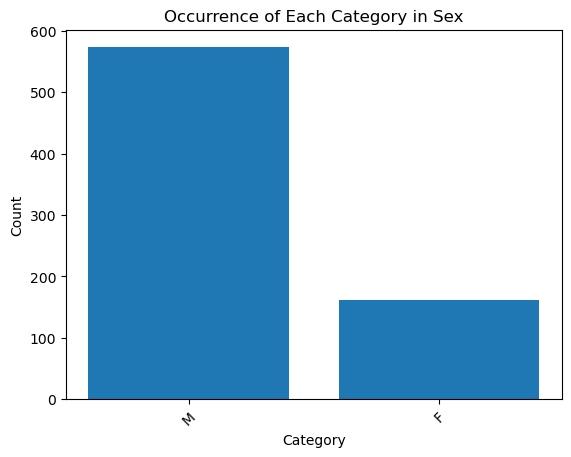

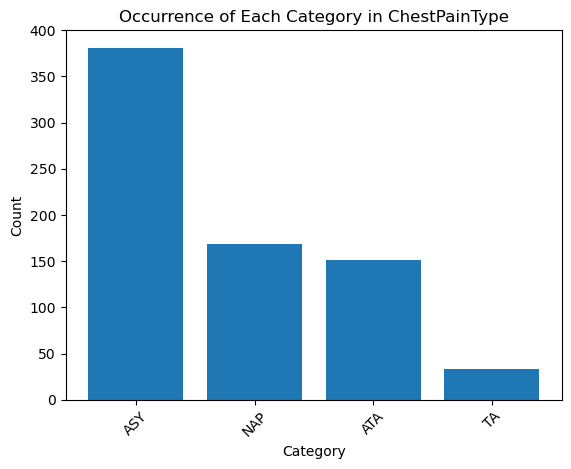

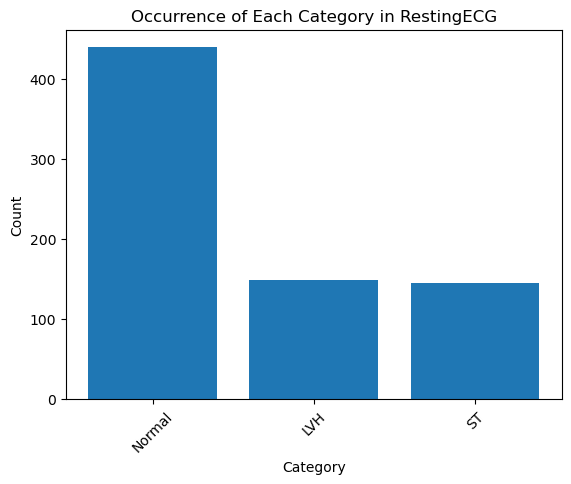

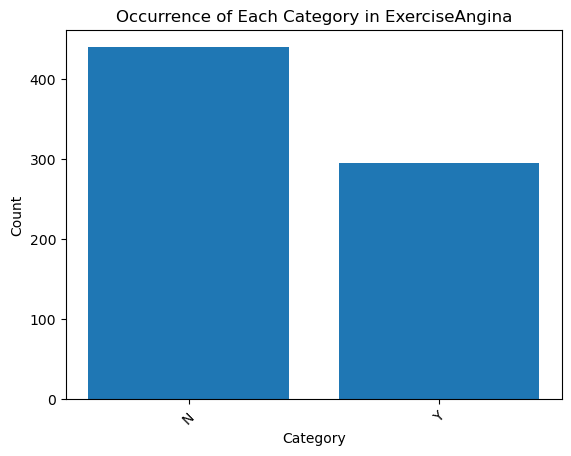

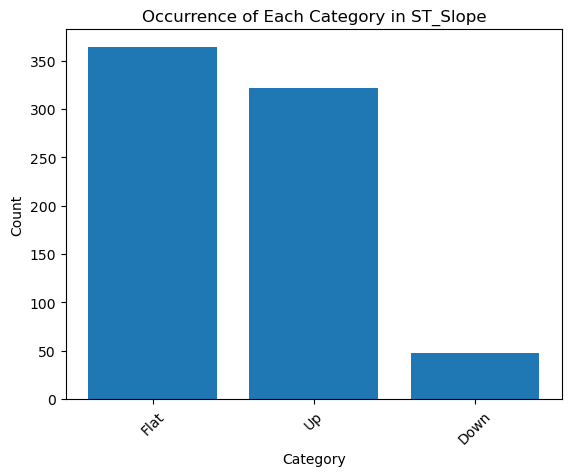

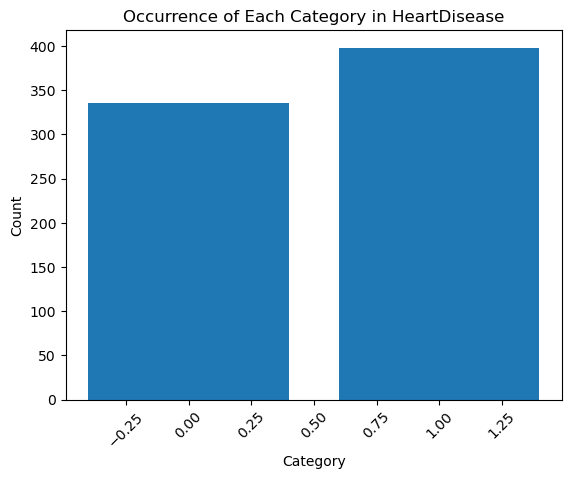

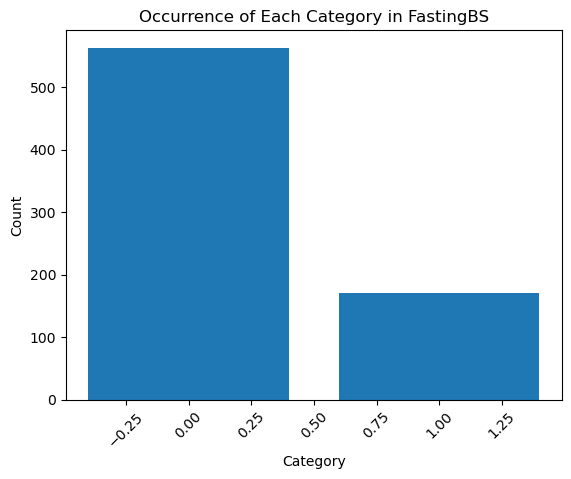

In [180]:
for col in categorical:
    plot_categorical(df_train_val, column=col)

In [141]:
'''df_train_val['Sex'] = pd.factorize(df_train_val['Sex'])[0]
df_train_val['ChestPainType'] = pd.factorize(df_train_val['ChestPainType'])[0]
df_train_val['RestingECG'] = pd.factorize(df_train_val['RestingECG'])[0]
df_train_val['ExerciseAngina'] = pd.factorize(df_train_val['ExerciseAngina'])[0]
df_train_val['ST_Slope'] = pd.factorize(df_train_val['ST_Slope'])[0]

df_test['Sex'] = pd.factorize(df_test['Sex'])[0]
df_test['ChestPainType'] = pd.factorize(df_test['ChestPainType'])[0]
df_test['RestingECG'] = pd.factorize(df_test['RestingECG'])[0]
df_test['ExerciseAngina'] = pd.factorize(df_test['ExerciseAngina'])[0]
df_test['ST_Slope'] = pd.factorize(df_test['ST_Slope'])[0]'''

df['Sex'] = pd.factorize(df['Sex'])[0]
df['ChestPainType'] = pd.factorize(df['ChestPainType'])[0]
df['RestingECG'] = pd.factorize(df['RestingECG'])[0]
df['ExerciseAngina'] = pd.factorize(df['ExerciseAngina'])[0]
df['ST_Slope'] = pd.factorize(df['ST_Slope'])[0]

df_train_val = df[:df_train_val.shape[0]]
df_test = df[df_train_val.shape[0]:]

In [142]:
X = df_train_val.drop(columns=['HeartDisease']).values
X_test = df_test.drop(columns=['HeartDisease']).values
y = df_train_val['HeartDisease'].values
y_test = df_test['HeartDisease'].values
X_st = standardize_data(X)
X_test = standardize_data(X_test)
#print(X_st)
X_train, X_val, y_train, y_val = train_test_split(X_st, y, test_size=0.2, random_state=42)

Lasso Regression

In [183]:
reg = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)
logreg = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)

In [190]:
logreg.C_[0]


0.3593813663804626

In [191]:
logreg.score(X_val, y_val)

0.8775510204081632

In [192]:
pred = logreg.predict(X_test).round()
f1Score = f1_score(y_test, pred)
bAccuracy = balanced_accuracy_score(y_test, pred)
print('f1 score: ', f1Score, 'balanced accuracy: ', bAccuracy)

f1 score:  0.834862385321101 balanced accuracy:  0.7987714987714988


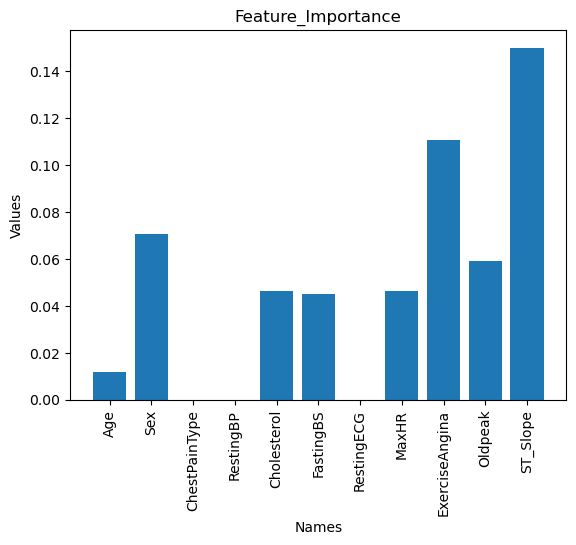

In [198]:
create_bar_plot(df_train_val.columns[0:11], np.abs(reg.coef_), title='Feature_Importance')

MLP

In [148]:
import tqdm
import copy
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        # print(epoch)
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [149]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(11, 10)
        #self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        #x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        #x = nn.functional.sigmoid(self.fc3(x))
        x = self.fc3(x)
        return x

In [150]:
train_loader = create_dataloaders_from_arrays(X_train, y_train, batch_size=32)
val_loader = create_dataloaders_from_arrays(X_val, y_val, batch_size=32)
test_loader = create_dataloaders_from_arrays(X_test, y_test, batch_size=32)

In [151]:
(train_loader.dataset[0])

(tensor([-0.3742, -0.5301, -0.1474,  0.4266,  0.3068, -0.5511,  0.4935,  0.1514,
          1.2199,  3.8151,  0.6181]),
 tensor(1.))

In [152]:
model = MyModel()
train_model(model, train_loader, val_loader, device='cpu', epochs=100)

Epoch: 1 	Training Loss: 0.657442
Epoch: 2 	Training Loss: 0.478640
Epoch: 3 	Training Loss: 0.364842
Epoch: 4 	Training Loss: 0.342542
Epoch: 5 	Training Loss: 0.317686
Epoch: 6 	Training Loss: 0.304105
Epoch: 7 	Training Loss: 0.289622
Epoch: 8 	Training Loss: 0.282417
Epoch: 9 	Training Loss: 0.279773
Epoch: 10 	Training Loss: 0.272946
Epoch: 11 	Training Loss: 0.266807
Epoch: 12 	Training Loss: 0.264647
Epoch: 13 	Training Loss: 0.258900
Epoch: 14 	Training Loss: 0.250008
Epoch: 15 	Training Loss: 0.255682
Epoch: 16 	Training Loss: 0.248031
Epoch: 17 	Training Loss: 0.240337
Epoch: 18 	Training Loss: 0.235907
Epoch: 19 	Training Loss: 0.244806
Epoch: 20 	Training Loss: 0.230494
Epoch: 21 	Training Loss: 0.226693
Epoch: 22 	Training Loss: 0.228359
Epoch: 23 	Training Loss: 0.224541
Epoch: 24 	Training Loss: 0.218930
Epoch: 25 	Training Loss: 0.215820
Epoch: 26 	Training Loss: 0.209563
Epoch: 27 	Training Loss: 0.206196
Epoch: 28 	Training Loss: 0.203335
Epoch: 29 	Training Loss: 0.2

In [153]:
model.to('cpu')
preds = make_predictions(model, X_test).round()
f1Score = f1_score(y_test, preds)
bAccuracy = balanced_accuracy_score(y_test, preds)
print('f1 score: ', f1Score, 'balanced accuracy: ', bAccuracy)

f1 score:  0.8430493273542601 balanced accuracy:  0.7988943488943488


In [154]:
def shap_predict_fn(data):
    model.eval()
    output = model(torch.tensor(data).float())
    return output.detach().numpy()
    
explainer = shap.KernelExplainer(shap_predict_fn, X_train[:20])
shap_values_1 = explainer.shap_values(X_train[0], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values_1[0], X_train[0], feature_names=df.columns[:-1])




#no disease: 0,1
#disease: 2,7

In [155]:
shap_values_2 = explainer.shap_values(X_train[1], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values_2[0], X_train[1], feature_names=df.columns[:-1])

In [156]:
shap_values_2 = explainer.shap_values(X_train[2], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values_2[0], X_train[2], feature_names=df.columns[:-1])

In [157]:
shap_values_2 = explainer.shap_values(X_train[7], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values_2[0], X_train[7], feature_names=df.columns[:-1])

  0%|          | 0/20 [00:00<?, ?it/s]

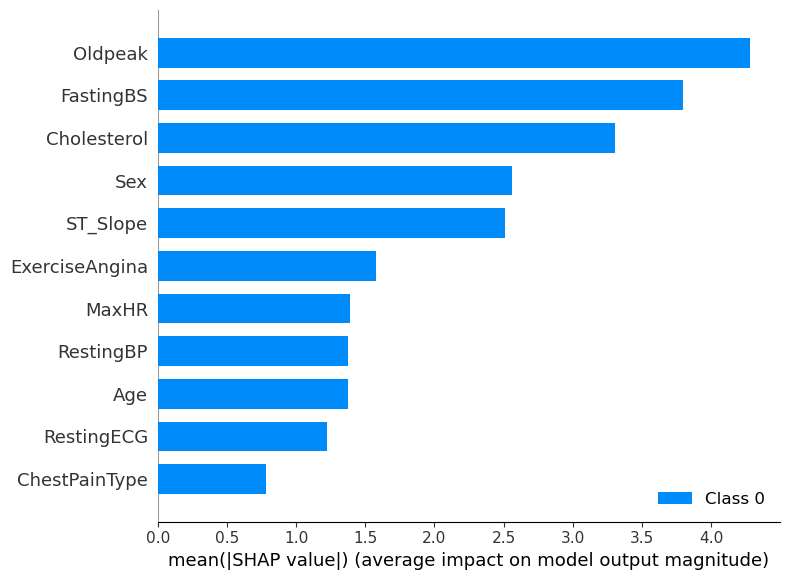

In [158]:
#explainer = shap.KernelExplainer(shap_predict_fn, X_train[:20])
shap_values = explainer.shap_values(X_train[:20], nsamples=500)
shap.summary_plot(shap_values, X_train[:20], feature_names=df.columns[:-1])


NAMs

In [159]:
class FeatureNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeatureNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.layer(x)

class My_NAM(nn.Module):
    def __init__(self, num_features):
        super(My_NAM, self).__init__()
        self.feature_nns = nn.ModuleList([FeatureNN(1, 1) for _ in range(num_features)])
        self.lastlayer = nn.Linear(num_features, 1)
        self.num_features = num_features

    def forward(self, x):
        out = torch.zeros(x.shape[0], self.num_features)
        for i, feature_nn in enumerate(self.feature_nns):
            out[:,i:i+1] += feature_nn(x[:, i:i+1])
        out = self.lastlayer(out)
        return out

In [160]:
NAM_model = My_NAM(11)
train_model(NAM_model, train_loader, val_loader, device='cpu', epochs=100)

Epoch: 1 	Training Loss: 0.456621
Epoch: 2 	Training Loss: 0.343804
Epoch: 3 	Training Loss: 0.334062
Epoch: 4 	Training Loss: 0.313166
Epoch: 5 	Training Loss: 0.309460
Epoch: 6 	Training Loss: 0.309629
Epoch: 7 	Training Loss: 0.317039
Epoch: 8 	Training Loss: 0.327514
Epoch: 9 	Training Loss: 0.308622
Epoch: 10 	Training Loss: 0.321789
Epoch: 11 	Training Loss: 0.325655
Epoch: 12 	Training Loss: 0.307484
Epoch: 13 	Training Loss: 0.311281
Epoch: 14 	Training Loss: 0.300214
Epoch: 15 	Training Loss: 0.317684
Epoch: 16 	Training Loss: 0.308317
Epoch: 17 	Training Loss: 0.303687
Epoch: 18 	Training Loss: 0.307750
Epoch: 19 	Training Loss: 0.305117
Epoch: 20 	Training Loss: 0.307802
Epoch: 21 	Training Loss: 0.308236
Epoch: 22 	Training Loss: 0.312562
Epoch: 23 	Training Loss: 0.303690
Epoch: 24 	Training Loss: 0.306063
Epoch: 25 	Training Loss: 0.305163
Epoch: 26 	Training Loss: 0.311275
Epoch: 27 	Training Loss: 0.311874
Epoch: 28 	Training Loss: 0.300612
Epoch: 29 	Training Loss: 0.3

In [161]:
print(torch.cuda.is_available())

False


In [162]:
NAM_model.to('cpu')
preds = make_predictions(NAM_model, X_test).round()
f1Score = f1_score(y_test, preds)
bAccuracy = balanced_accuracy_score(y_test, preds)
print('f1 score: ', f1Score, 'balanced accuracy: ', bAccuracy)

f1 score:  0.868421052631579 balanced accuracy:  0.8216216216216217


In [163]:
def plot_model_function(model, x_range=(-10, 10), weight=1):
    model.eval()
    x = torch.linspace(*x_range, 1000).unsqueeze(-1)
    y = model(x).detach().numpy() * weight
    plt.plot(x.numpy(), y)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title('Model Function')
    plt.grid(True)
    plt.show()

(1, 11)


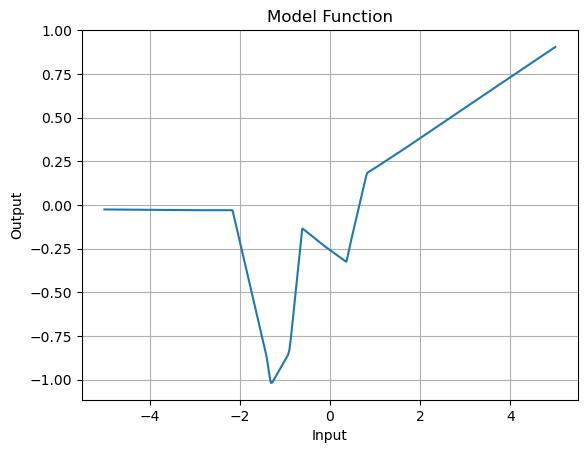

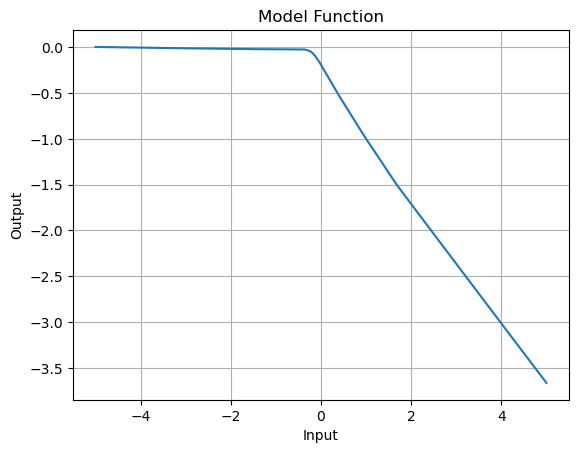

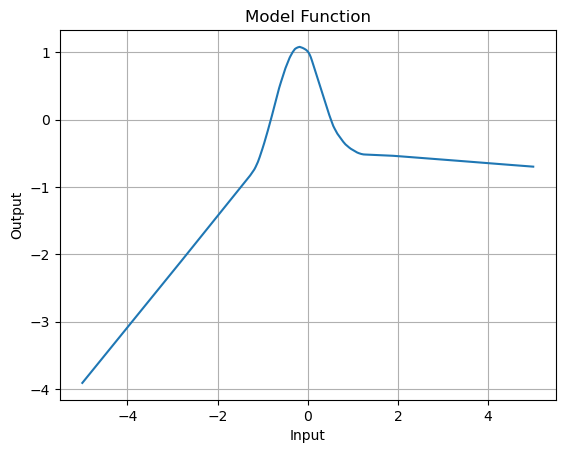

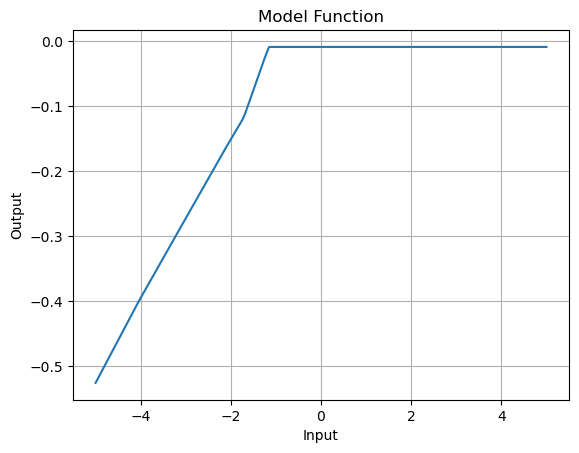

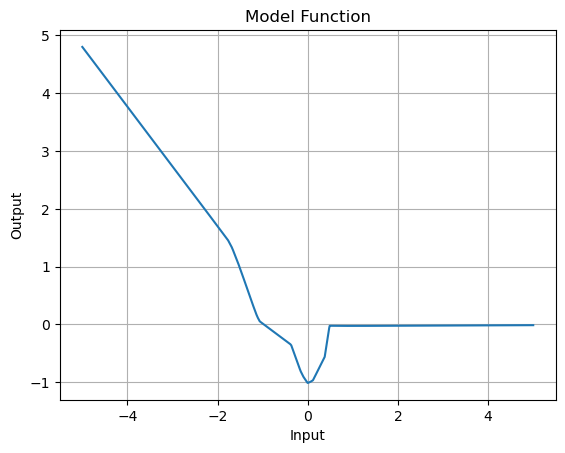

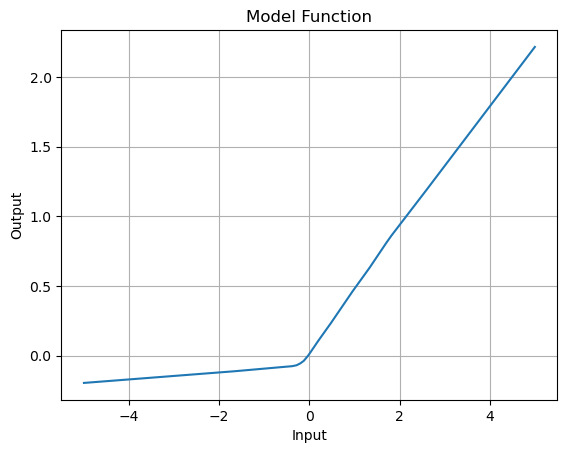

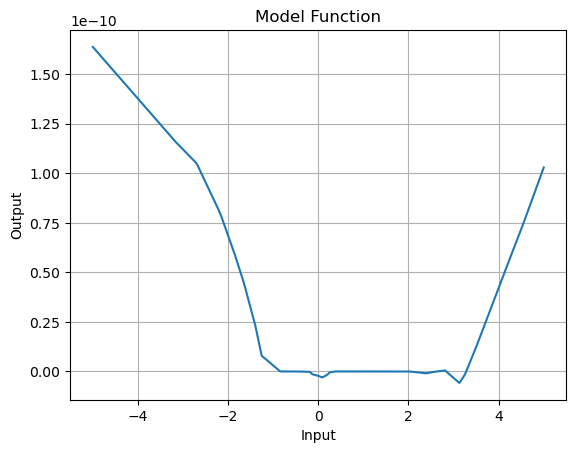

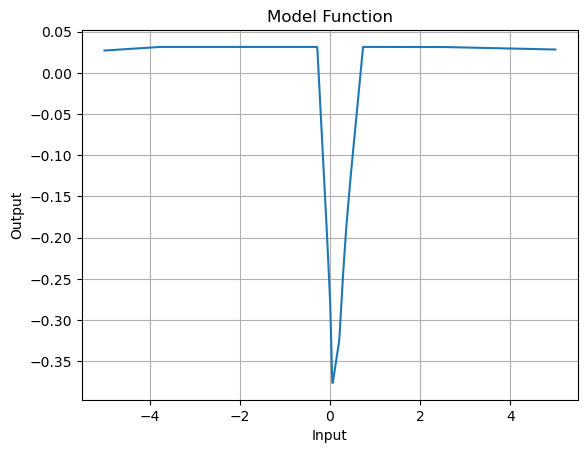

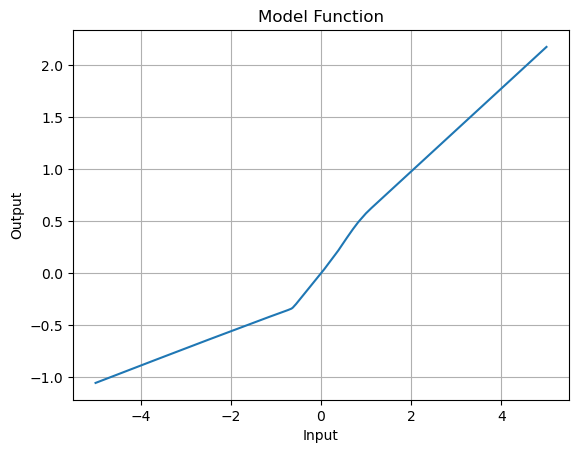

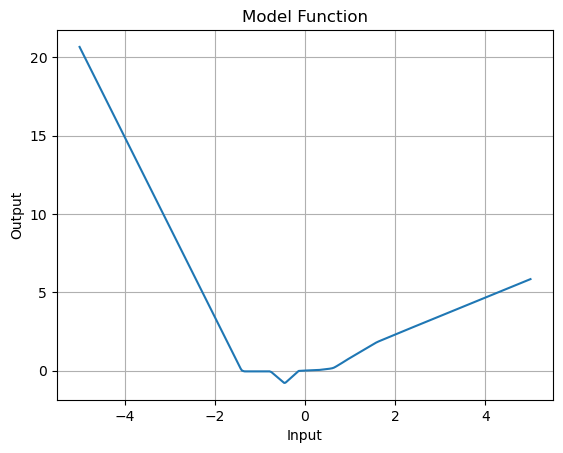

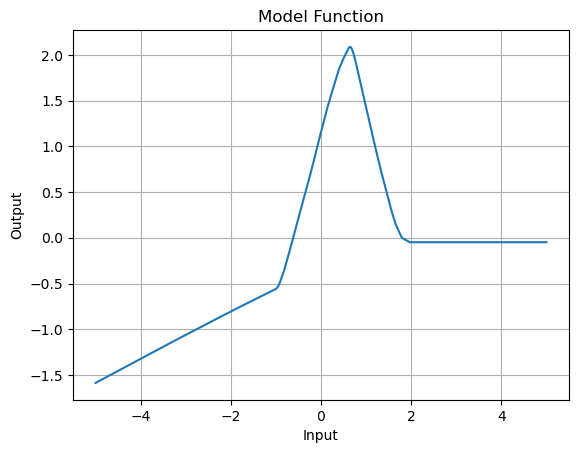

In [164]:
state_dict = NAM_model.state_dict()
feature_importances = state_dict['lastlayer.weight'].detach().numpy()
print(feature_importances.shape)
#create_bar_plot(df.columns[:-1], np.abs(feature_importances[0]))

for i,mod in enumerate(NAM_model.feature_nns):
    plot_model_function(mod, x_range=(-5, 5), weight=feature_importances[0][i])